# Predicting marginal electricity generation from power plants in ERCOT

## Index
- [Background](#Background)  
- [Data collection](#Data-collection)  
- [Data cleaning/merging](#Data-cleaning/merging)  
    - [ERCOT data](#ERCOT-data)  
    - [EIA data](#EIA-data)  
        - [Power plant generation and fuel data from EIA-923](#Power-plant-generation-and-fuel-data-from-EIA-923)  
        - [Power plant capacity from EIA-860](#Power-plant-capacity-from-EIA-860)  
    - [EPA data](#EPA-data)  
- [Merging data for clustering](#Merging-data-for-clustering)  
- [Clustering](#Clustering)
- [Calculating hourly generation change](#Calculating-hourly-generation-change)  
- [Model training](#Model-training)

## Background
Most dispatchable electricity - electricity that can be produced on-demand - in the U.S. is generated at fossil power plants[[1]](#References). The plant, or plants, that generate more electricity in response to increased demand are called marginal generating units (MGUs). Models that predict MGUs generally fall into one of two categories: regression-based or unit-commitment economic dispatch[[2]](#References). The first category can account for effects (e.g. imperfect information) that are ignored in the second by examining real-world behavior. However, models that simply regress on historical behavior are ill-suited to making predictions about future grid conditions that differ from the data they were trained on. Applying machine learning techniques to energy sector analyses represents a pathway for potential improvements in the prediction of MGU behavior, and understanding the environmental impacts of energy transitions. This area of research is especially important as researchers and policy makers try to predict the economic and environmental impacts of vehicle electrification, demand-response management, and large scale deployment of variable renewable generating sources like wind and solar.


The goal of this project is to build a model that can predict the type of fossil MGU that will provide electricity for additional demand when given the current set of grid conditions. This type of problem can be difficult to solve, especially when the model is also trying to predict grid conditions like demand or wind generation. We are simplifying the model by treating these inputs as exogenous - the time of day or day of the year doesn't matter.

Predicting which individual power plant will provide marginal generation under a given set of grid conditions is also difficult. Individual facilities might go down for maintanence or otherwise not respond to changing grid conditions in an expected manner. We group individual fossil power plants based on their historical operating characteristics (average heat rate, capacity, capacity factor, and 95th percentile 1-hour ramp rate) using k-means clustering. The model treats each group as a single generating unit, and predicts it's change in generation given a change in grid demand.

## Import Libraries

In [115]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import glob
import re
import cPickle as pickle
import gzip
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor

## Data collection
Our dataset covers 9 years of operation in the ERCOT power grid, which covers most of Texas. Data sources include:

- ERCOT [[3]](#References)
    - Hourly demand for power in Megawatts (MW)
    - Hourly generation of wind power and total installed capacity (MW)
- Energy Information Agency (EIA)
    - Annual generation for each power plant (MWh) and fuels used for generation [[4]](#References)
    - Capacity of each power plant in a given year (MW) [[5]](#References)
    - Monthly natural gas prices for electric customers in Texas [[6]](#References)
    - Quarterly coal prices for electric consumers in Texas [[7]](#References)
- Environmental Protection Agency (EPA)
    - Hourly gross generation at fossil-fuel power plants larger than 25 MW [[8]](#References)

All datasets were downloaded as Excel or CSV files. All of the raw data files combined are larger than 1 GB, and can be found on the [GitHub repository](https://github.com/gschivley/ERCOT_power) for this project.

## Data cleaning/merging
Because the datasets in this project came from a number of different sources and are given on a wide range of time scales, each had to be loaded, cleaned, and put in the correct form before they could all be merged.

### ERCOT data
ERCOT hourly data on demand (load), wind generation, and wind capacity can be downloaded for a full year in a single Excel file. File extensions include both .xls and .xlsx. The 9 files did not have consistent column names across all years. Changes were made by hand in Excel.

Set up all the file paths, and column names to keep.

In [2]:
path = '../Raw Data/ERCOT/Hourly wind generation'
full_xls = os.path.join(path, '*.xls')
full_xlsx = os.path.join(path, '*.xlsx')

files = glob.glob(full_xls)
files.extend(glob.glob(full_xlsx))

In [3]:
cols = ['ERCOT Load, MW', 'Total Wind Installed, MW',
       'Total Wind Output, MW', 'Wind Output, % of Installed',
       'Wind Output, % of Load', '1-hr MW change', '1-hr % change']

Read the excel files, combine them into a single dataframe, and only keep the columns we need.

In [4]:
ercot = pd.concat([pd.read_excel(fn, sn='numbers', index_col=0) for fn in files])
ercot = ercot.loc[:,cols]
ercot.sort_index(inplace=True)
ercot = ercot.iloc[:-1,:]

Create a few plots to ensure the data looks good.

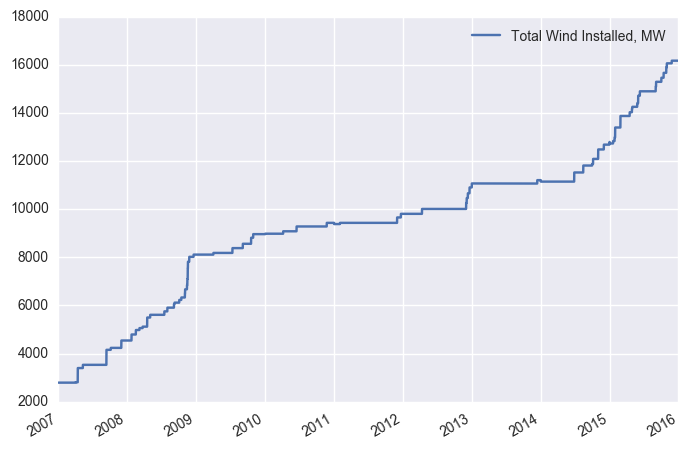

In [5]:
ercot.plot(y='Total Wind Installed, MW', use_index=True)

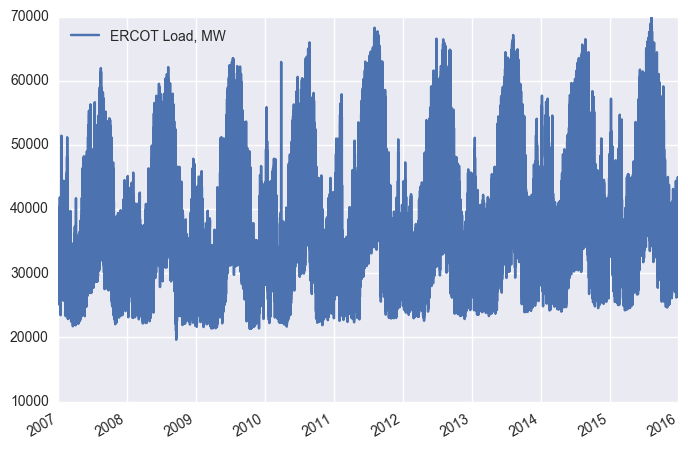

In [6]:
ercot.plot(y='ERCOT Load, MW', use_index=True)

In [7]:
ercot.head()

ERCOT Load, MW  Total Wind Installed, MW  \
2007-01-01 00:00:00         30428.0                    2790.0   
2007-01-01 01:00:00         30133.0                    2790.0   
2007-01-01 02:00:00         29941.0                    2790.0   
2007-01-01 03:00:00         29949.0                    2790.0   
2007-01-01 04:00:00         30248.0                    2790.0   

                     Total Wind Output, MW  Wind Output, % of Installed  \
2007-01-01 00:00:00                 1074.0                    38.494624   
2007-01-01 01:00:00                  922.6                    33.068100   
2007-01-01 02:00:00                  849.2                    30.437276   
2007-01-01 03:00:00                 1056.3                    37.860215   
2007-01-01 04:00:00                  837.1                    30.003584   

                     Wind Output, % of Load  1-hr MW change  1-hr % change  
2007-01-01 00:00:00                3.529644             NaN            NaN  
2007-01-01 01:00:00                3.061760          -151.4     -14.096834  
2007-01-01 02:00:00                2.836245           -73.4      -7.955777  
2007-01-01 03:00:00                3.526996           207.1      24.387659  
2007-01-01 04:00:00                2.767456          -219.2     -20.751680

In [8]:
ercot.loc[:,'Net Load (MW)'] = ercot.loc[:,'ERCOT Load, MW'] - ercot.loc[:,'Total Wind Output, MW']

In [9]:
ercot.loc[1:,'Net Load Change (MW)'] = ercot.iloc[1:,-1].values - ercot.iloc[:-1,-1].values

In [10]:
ercot.loc[:,'DATETIME'] = pd.to_datetime(ercot.index)

In [11]:
ercot.head()

ERCOT Load, MW  Total Wind Installed, MW  \
2007-01-01 00:00:00         30428.0                    2790.0   
2007-01-01 01:00:00         30133.0                    2790.0   
2007-01-01 02:00:00         29941.0                    2790.0   
2007-01-01 03:00:00         29949.0                    2790.0   
2007-01-01 04:00:00         30248.0                    2790.0   

                     Total Wind Output, MW  Wind Output, % of Installed  \
2007-01-01 00:00:00                 1074.0                    38.494624   
2007-01-01 01:00:00                  922.6                    33.068100   
2007-01-01 02:00:00                  849.2                    30.437276   
2007-01-01 03:00:00                 1056.3                    37.860215   
2007-01-01 04:00:00                  837.1                    30.003584   

                     Wind Output, % of Load  1-hr MW change  1-hr % change  \
2007-01-01 00:00:00                3.529644             NaN            NaN   
2007-01-01 01:00:00                3.061760          -151.4     -14.096834   
2007-01-01 02:00:00                2.836245           -73.4      -7.955777   
2007-01-01 03:00:00                3.526996           207.1      24.387659   
2007-01-01 04:00:00                2.767456          -219.2     -20.751680   

                     Net Load (MW)  Net Load Change (MW)            DATETIME  
2007-01-01 00:00:00        29354.0                   NaN 2007-01-01 00:00:00  
2007-01-01 01:00:00        29210.4                -143.6 2007-01-01 01:00:00  
2007-01-01 02:00:00        29091.8                -118.6 2007-01-01 02:00:00  
2007-01-01 03:00:00        28892.7                -199.1 2007-01-01 03:00:00  
2007-01-01 04:00:00        29410.9                 518.2 2007-01-01 04:00:00

Export Dataframe to csv and reload to avoid pre-processing of data

In [12]:
filename = 'Ercot_Data.csv'
fullpath = os.path.join(filename)
ercot.to_csv(fullpath)

In [13]:
filename = 'Ercot_Data.csv'
fullpath = os.path.join(filename)

ercot = pd.read_csv(fullpath, index_col=0)

In [14]:
ercot.loc[:,'DATETIME'] = pd.to_datetime(ercot.index)

### EIA data
We use EIA data for information about power plants and fuel prices.

#### Power plant generation and fuel data from EIA-923

In [15]:
#Iterate through the directory to find all the files to import
path = os.path.join('../Raw Data/EIA Data', '923-No_Header')
full_path = os.path.join(path, '*.*')

eiaNames = os.listdir(path)

#Rename the keys for easier merging later
fileNameMap = {'EIA923 SCHEDULES 2_3_4_5 Final 2010.xls':2010,
                'EIA923 SCHEDULES 2_3_4_5 M Final 2009 REVISED 05252011.XLS':2009,
                'eia923December2008.xls':2008,
                'EIA923_Schedules_2_3_4_5_2011_Final_Revision.xlsx':2011,
                'EIA923_Schedules_2_3_4_5_2012_Final_Release_12.04.2013.xlsx':2012,
                'EIA923_Schedules_2_3_4_5_2013_Final_Revision.xlsx':2013,
                'EIA923_Schedules_2_3_4_5_M_12_2014_Final_Revision.xlsx':2014,
                'EIA923_Schedules_2_3_4_5_M_12_2015_Final.xlsx':2015,
                'f906920_2007.xls':2007}

#Load the files into data frames, one df per file
eiaDict = {fileNameMap[fn]:pd.read_excel(os.path.join(path, fn)) for fn in eiaNames}
eiaDict = {key:val[val["NERC Region"] == "TRE"] for key, val in eiaDict.iteritems()}

In [16]:
#Dict of values to replace to standardize column names across all dataframes
monthDict = {"JANUARY":"JAN",
           "FEBRUARY":"FEB",
           "MARCH":"MAR",
           "APRIL":"APR",
           "MAY":"MAY",
           "JUNE":"JUN",
           "JULY":"JUL",
           "AUGUST":"AUG",
           "SEPTEMBER":"SEP",
           "OCTOBER":"OCT",
           "NOVEMBER":"NOV",
           "DECEMBER":"DEC"}
           
replaceDict = {"ELECTRIC":"ELEC",
               "&":"AND",
               "I.D.":"ID",
               "MMBTUPER":"MMBTU_PER"}
               
#Add "MMBTUMON" : "MMBTU_MON" to be replaced
for month in monthDict.values():
    replaceDict["MMBTU"+month] = "MMBTU_" + month

#Replace the column name
def rename(col):
    for old, new in monthDict.iteritems():
        col = col.replace(old, new)
        
    for old, new in replaceDict.iteritems():
        col = col.replace(old, new)
        
    col = col.replace("MMBTUS", "MMBTU")
    return col
    
#Iterate through each column name of each dataframe to standardize
for key, df in eiaDict.iteritems():
    colNames = [name.replace("\n", "_").replace(" ", "_").strip().upper() for name in df.columns]
    colNames = [rename(col) for col in colNames]
    eiaDict[key].columns = colNames

In [17]:
#Define the columns that are necessary but are not summable
allCols = eiaDict[fileNameMap.values()[0]].columns
nonSumCols = ["PLANT_ID", "PLANT_NAME", "YEAR"]

#Define the columns that contain the year's totals (Used to calc fuel type %)
yearCols = ["TOTAL_FUEL_CONSUMPTION_QUANTITY", "ELEC_FUEL_CONSUMPTION_QUANTITY",
            "TOTAL_FUEL_CONSUMPTION_MMBTU", "ELEC_FUEL_CONSUMPTION_MMBTU",
            "NET_GENERATION_(MEGAWATTHOURS)"]

#Define the columns that are necessary and summable
sumCols = []
sumCols.extend(yearCols)
# regex = re.compile(r"^ELEC_QUANTITY_.*")
# sumCols.extend([col for col in allCols if regex.search(col)])
regex = re.compile(r"^MMBTU_PER_UNIT_.*")
sumCols.extend([col for col in allCols if regex.search(col)])
regex = re.compile(r"^TOT_MMBTU_.*")
sumCols.extend([col for col in allCols if regex.search(col)])
regex = re.compile(r"^ELEC_MMBTUS_.*")
sumCols.extend([col for col in allCols if regex.search(col)])
regex = re.compile(r"^NETGEN_.*")
sumCols.extend([col for col in allCols if regex.search(col)])

Get a list of all the different fuel type codes.

In [18]:
fuelTypes = []
fuelTypes.extend([fuelType for df in eiaDict.values() for fuelType in df["REPORTED_FUEL_TYPE_CODE"].tolist()])
fuelTypes = set(fuelTypes)

EIA-923 splits out electricity generated at a power plant generating units and the type of fuel. We are aggregating everything to the facility level and assigning a single fuel type to the plant. This fuel type is used to filter out non-fossil plants and for analysis of what types of power plants are in the clusters.

Three parts to aggregate by facility, and to calculate the % of each type of fuel. This will take a few minutes to run.  

The end result is aggEIADict.

In [19]:
#Actually calculate the % fuel type for each facility grouping
def calcPerc(group, aggGroup, fuelType, col):
    #Check to see if the facility has a record for the fuel type, and if the total column > 0
    if len(group[group["REPORTED_FUEL_TYPE_CODE"] == fuelType]) > 0 and aggGroup[col] > 0:
        #summing fuel type because a facility may have multiple plants with the same fuel type        
        return float((group[group["REPORTED_FUEL_TYPE_CODE"] == fuelType][col]).sum())/aggGroup[col] 
    else:
        return 0

#Perform the aggregation on facility level
def aggAndCalcPerc(group):
    aggGroup = group.iloc[0][nonSumCols] #Get the non-agg columns
    aggGroup = aggGroup.append(group[sumCols].sum())   #Aggregate the agg columns and append to non-agg
    percCols = {col + " %" + fuelType:calcPerc(group, aggGroup, fuelType, col) for col in yearCols for fuelType in fuelTypes}
    aggGroup = aggGroup.append(pd.Series(percCols))
    return aggGroup    

#Iterate through each dataframe to perform aggregation by facility
aggEIADict = dict()
for key, df in eiaDict.iteritems():
    gb = df.groupby(by="PLANT_ID")
    #aggGroup will be a list of panda series, each series representing a facility
    aggGroup = [aggAndCalcPerc(gb.get_group(group)) for group in gb.groups]
    aggEIADict[key] = pd.DataFrame(aggGroup)

**Combine all df's from the dict into one df**

Concat all dataframes, reset the index, determine the primary fuel type for each facility, filter to only include fossil power plants

In [20]:
all923 = pd.concat(aggEIADict)
all923.reset_index(drop=True, inplace=True)

In [21]:
def top_fuel(row):
    #Fraction of largest fuel for electric heat input 
    try:
        fuel = row.iloc[1:27].idxmax()[29:]
    except:
        return None
    return fuel

In [22]:
all923['FUEL'] = all923.apply(top_fuel, axis=1)

Because the EPA data only includes power plants that burn fossil fuels, we are only keeping these facilities. The codes below correspond to:
- Diesel fuel oil
- Lignite coal
- Natural gas
- Petroleum coke
- Subbituminous coal

In [23]:
fossil923 = all923.loc[all923['FUEL'].isin(['DFO', 'LIG', 'NG', 'PC', 'SUB'])]

In [24]:
fossil923.head()

ELEC_FUEL_CONSUMPTION_MMBTU  ELEC_FUEL_CONSUMPTION_MMBTU %AB  \
3                   171279117.0                              0.0   
11                   11685020.0                              0.0   
12                     157326.0                              0.0   
13                     891411.0                              0.0   
14                   19445694.0                              0.0   

    ELEC_FUEL_CONSUMPTION_MMBTU %BIT  ELEC_FUEL_CONSUMPTION_MMBTU %BLQ  \
3                                0.0                               0.0   
11                               0.0                               0.0   
12                               0.0                               0.0   
13                               0.0                               0.0   
14                               0.0                               0.0   

    ELEC_FUEL_CONSUMPTION_MMBTU %DFO  ELEC_FUEL_CONSUMPTION_MMBTU %JF  \
3                            0.00082                              0.0   
11                           0.00000                              0.0   
12                           0.00000                              0.0   
13                           0.00000                              0.0   
14                           0.00000                              0.0   

    ELEC_FUEL_CONSUMPTION_MMBTU %LFG  ELEC_FUEL_CONSUMPTION_MMBTU %LIG  \
3                                0.0                          0.403995   
11                               0.0                          0.000000   
12                               0.0                          0.000000   
13                               0.0                          0.000000   
14                               0.0                          0.000000   

    ELEC_FUEL_CONSUMPTION_MMBTU %MWH  ELEC_FUEL_CONSUMPTION_MMBTU %NG  ...   \
3                                0.0                              0.0  ...    
11                               0.0                              1.0  ...    
12                               0.0                              1.0  ...    
13                               0.0                              1.0  ...    
14                               0.0                              1.0  ...    

    TOT_MMBTU_JAN  TOT_MMBTU_JUL  TOT_MMBTU_JUN  TOT_MMBTU_MAR  TOT_MMBTU_MAY  \
3     1.39678e+07    1.50848e+07    1.40674e+07    1.47215e+07     1.3538e+07   
11    1.34154e+06         939196         854170         755772    1.20999e+06   
12         109526         140525         130156         108289         111163   
13         230890         296241         274381         228286         234341   
14     2.0661e+06    2.02784e+06    2.52676e+06         951082    1.53421e+06   

    TOT_MMBTU_NOV  TOT_MMBTU_OCT  TOT_MMBTU_SEP  YEAR  FUEL  
3     1.45648e+07    1.49483e+07    1.39296e+07  2007   SUB  
11         725064    1.00316e+06    1.04083e+06  2007    NG  
12          91045         115127         136948  2007    NG  
13         191932         242701         288700  2007    NG  
14    1.17530e+06         842856    1.09479e+06  2007    NG  

[5 rows x 175 columns]

#### Export the EIA 923 data dataframe as csv

In [25]:
filename = 'Fossil_EIA_923.csv'
fullpath = os.path.join(filename)
fossil923.to_csv(fullpath, index=None)

In [26]:
## Reload data from File to avoid running the data pre-processing steps:
filename = 'Fossil_EIA_923.csv'
fullpath = os.path.join(filename)
fossil923 = pd.read_csv(fullpath)

#### Power plant capacity from EIA-860

In [27]:
# Iterate through the directory to find all the files to import
path = os.path.join('../Raw Data/EIA Data', '860-No_Header')
full_path = os.path.join(path, '*.*')

eia860Names = os.listdir(path)

# Rename the keys for easier merging later
fileName860Map = {  'GenY07.xls':2007,
                    'GenY08.xls':2008,
                    'GeneratorY09.xls':2009,
                    'GeneratorsY2010.xls':2010,
                    'GeneratorY2011.xlsx':2011,
                    'GeneratorY2012.xlsx':2012,
                    '3_1_Generator_Y2013.xlsx':2013,
                    '3_1_Generator_Y2014.xlsx':2014,
                    '3_1_Generator_Y2015.xlsx':2015}

#Load the files into data frames, one df per file
eia860Dict = {fileName860Map[fn]:pd.read_excel(os.path.join(path, fn)) for fn in eia860Names}  

In [28]:
#Dict of values to replace to standardize column names across all dataframes
renameDict = {  "PLNTCODE":"PLANT_ID",
                "PLANT_CODE":"PLANT_ID",
                "Plant Code":"PLANT_ID",
                "NAMEPLATE":"NAMEPLATE_CAPACITY(MW)",
                "Nameplate Capacity (MW)":"NAMEPLATE_CAPACITY(MW)"}

#Replace the column name
def rename860(col):
    for old, new in renameDict.iteritems():
        col = col.replace(old, new)
    return col

#Iterate through each column name of each dataframe to standardize and select columns 'PLANT_ID', 'NAMEPLATE_CAPACITY(MW)'
for key, df in eia860Dict.iteritems():
    colNames = [rename860(col) for col in df.columns]
    eia860Dict[key].columns = colNames
    eia860Dict[key] = eia860Dict[key][["PLANT_ID", "NAMEPLATE_CAPACITY(MW)"]]

Power plants can include multiple generating units. We are aggregating the total generating capacity of units in the EIA-860 database to the facility level.

In [29]:
# Iterate through each dataframe to perform aggregation by PLANT_ID
for key, df in eia860Dict.iteritems():
    gb = df.groupby(by='PLANT_ID').apply(lambda x: x['NAMEPLATE_CAPACITY(MW)'].sum())
    eia860Dict[key]['NAMEPLATE_CAPACITY(MW)'] = eia860Dict[key].PLANT_ID.apply(gb.get_value)
    eia860Dict[key] = eia860Dict[key].drop_duplicates(subset=['PLANT_ID', 'NAMEPLATE_CAPACITY(MW)'])
    eia860Dict[key] = eia860Dict[key].sort_values(by='PLANT_ID').reset_index(drop=True)

In [30]:
eia860Dict[2007].head()

PLANT_ID  NAMEPLATE_CAPACITY(MW)
0         2                    45.0
1         3                  2671.4
2         4                   225.0
3         7                   138.0
4         8                  1416.7

### Fuel price data
**Need to decide what level of merging to include in this section.**

Start with natural gas price

In [31]:
path = os.path.join('../Raw Data/EIA data', 'Natural gas price', 'N3045TX3m.xls')
ng_price = pd.read_excel(path, sheetname='Data 1', header=2)

In [32]:
ng_price.rename(columns={"Texas Natural Gas Price Sold to Electric Power Consumers (Dollars per Thousand Cubic Feet)":
                         "NG Price ($/mcf)"}, inplace=True)

In [33]:
ng_price.loc[:,'Month'] = ng_price.loc[:,'Date'].apply(lambda x: x.month)
ng_price.loc[:,'Year'] = ng_price.loc[:,'Date'].apply(lambda x: x.year)

In [34]:
ng_price.tail()

Date  NG Price ($/mcf)  Month  Year
170 2016-03-15              1.91      3  2016
171 2016-04-15              2.14      4  2016
172 2016-05-15              2.17      5  2016
173 2016-06-15              2.62      6  2016
174 2016-07-15              2.95      7  2016

#### Coal data

In [35]:
path = os.path.join('../Raw Data/EIA data', 'Coal prices', 'Texas electric sector coal price.xlsx')
coal_temp = pd.read_excel(path, sheetname='Sheet1')

In [36]:
coal_temp.loc[:,'Quarter'] = coal_temp.loc[:,'Date'].apply(lambda x: int(x[1]))
coal_temp.loc[:,'Year'] = coal_temp.loc[:,'Date'].apply(lambda x: int(x[-4:]))

In [37]:
coal_temp.head()

Date  All coal  Lignite  Subbituminous  Quarter  Year
0  Q1 2008     24.32    19.38          26.72        1  2008
1  Q2 2008     24.94    19.36          28.21        2  2008
2  Q3 2008     25.91    20.11          29.23        3  2008
3  Q4 2008     25.42    21.26          28.30        4  2008
4  Q1 2009     25.92    22.40          27.88        1  2009

#### Make up data for 2007
The EIA source only goes back to 2008. Use average 2008 price for 2007.

In [38]:
coal_2007 = pd.DataFrame(columns=coal_temp.columns)
coal_2007['Quarter'] = [1,2,3,4]
coal_2007['Year'] = 2007
for coal in ['All coal', 'Lignite', 'Subbituminous']:
    coal_2007[coal] = coal_temp.loc[coal_temp['Year']==2008,coal].mean()

In [39]:
coal_temp = coal_temp.append(coal_2007)

In [40]:
coal_temp.tail()

Date  All coal  Lignite  Subbituminous  Quarter  Year
32  Q1 2016   26.4400  22.6100         31.430        1  2016
0       NaN   25.1475  20.0275         28.115        1  2007
1       NaN   25.1475  20.0275         28.115        2  2007
2       NaN   25.1475  20.0275         28.115        3  2007
3       NaN   25.1475  20.0275         28.115        4  2007

In [41]:
# Create a time dataframe grom 2007-2015
df = pd.DataFrame(pd.date_range('2007-1-15', periods=12*9, freq='M'), columns=['tempdate'])
df.loc[:,'Quarter'] = df.loc[:,'tempdate'].apply(lambda x: x.quarter)
df.loc[:,'Month'] = df.loc[:,'tempdate'].apply(lambda x: x.month)
df.loc[:,'Year'] = df.loc[:,'tempdate'].apply(lambda x: x.year)


In [42]:
coal_price = pd.merge(coal_temp, df, on=['Quarter', 'Year'])

In [43]:
coal_price.head()

Date  All coal  Lignite  Subbituminous  Quarter  Year   tempdate  Month
0  Q1 2008     24.32    19.38          26.72        1  2008 2008-01-31      1
1  Q1 2008     24.32    19.38          26.72        1  2008 2008-02-29      2
2  Q1 2008     24.32    19.38          26.72        1  2008 2008-03-31      3
3  Q2 2008     24.94    19.36          28.21        2  2008 2008-04-30      4
4  Q2 2008     24.94    19.36          28.21        2  2008 2008-05-31      5

Combine fuel dataframes

In [44]:
fuel_price = pd.merge(ng_price, coal_price, how='right', on=['Month', 'Year'])
fuel_price.drop(['Date_x', 'Date_y', 'tempdate', 'Quarter'], axis=1, inplace=True)

In [48]:
fuel_price.head()

NG Price ($/mcf)  Month  Year  All coal  Lignite  Subbituminous
0              6.42      1  2007   25.1475  20.0275         28.115
1              7.34      2  2007   25.1475  20.0275         28.115
2              6.90      3  2007   25.1475  20.0275         28.115
3              7.29      4  2007   25.1475  20.0275         28.115
4              7.51      5  2007   25.1475  20.0275         28.115

Save the dataframe to csv

In [46]:
filename = 'Fuel_Prices.csv'
fullpath = os.path.join(filename)
fuel_price.to_csv(fullpath, index=None)

In [47]:
## Reload data from File to avoid running the data pre-processing steps:
filename = 'Fuel_Prices.csv'
fullpath = os.path.join(filename)
fuel_price = pd.read_csv(fullpath)

In [49]:
fuel_price.head()

NG Price ($/mcf)  Month  Year  All coal  Lignite  Subbituminous
0              6.42      1  2007   25.1475  20.0275         28.115
1              7.34      2  2007   25.1475  20.0275         28.115
2              6.90      3  2007   25.1475  20.0275         28.115
3              7.29      4  2007   25.1475  20.0275         28.115
4              7.51      5  2007   25.1475  20.0275         28.115

### EPA data
EPA hourly data is stored in a series of .txt files that each cover a 6 month period.

In [50]:
#Read the EPA files into a dataframe
path2 = os.path.join('../Raw Data/EPA air markets')
epaNames = os.listdir(path2)
filePaths = {dn:os.path.join(path2, dn, "*.txt") for dn in epaNames}
filePaths = {dn:glob.glob(val) for dn, val in filePaths.iteritems()}
epaDict = {key:pd.read_csv(fp, index_col = False) for key, val in filePaths.iteritems() for fp in val}

The DataFrames in epaDict contain all power plants in Texas. We can filter on NERC REGION so that it only includes ERCOT.

In [51]:
#Rename the column names to remove the leading space.
for key, df in epaDict.iteritems():
    colNames = [name.upper().strip() for name in df.columns]
    colNames[colNames.index("FACILITY ID (ORISPL)")] = "PLANT_ID"
    epaDict[key].columns = colNames
    
#Convert DATE to datetime object
#Add new column DATETIME with both date and hour
for key, df in epaDict.iteritems():
    epaDict[key]["DATE"] = pd.to_datetime(df["DATE"])
    epaDict[key]['DATETIME'] = df['DATE'] + pd.to_timedelta(df['HOUR'], unit='h')

In [52]:
#Boolean filter to only keep ERCOT plants
for key, df in epaDict.iteritems():
    epaDict[key] = df[df["NERC REGION"] == "ERCOT"].reset_index(drop = True)

In [53]:
epaDict['2015 July-Dec'].head()

STATE    FACILITY NAME  PLANT_ID  YEAR       DATE  HOUR  GROSS LOAD (MW)  \
0    TX  Barney M. Davis      4939  2015 2015-07-01     0              NaN   
1    TX  Barney M. Davis      4939  2015 2015-07-01     1              NaN   
2    TX  Barney M. Davis      4939  2015 2015-07-01     2              NaN   
3    TX  Barney M. Davis      4939  2015 2015-07-01     3              NaN   
4    TX  Barney M. Davis      4939  2015 2015-07-01     4              NaN   

   STEAM LOAD (1000LB/HR)  SO2 (POUNDS)  NOX (POUNDS)  CO2 (SHORT TONS)  \
0                     NaN           NaN           NaN               NaN   
1                     NaN           NaN           NaN               NaN   
2                     NaN           NaN           NaN               NaN   
3                     NaN           NaN           NaN               NaN   
4                     NaN           NaN           NaN               NaN   

   EPA REGION NERC REGION  COUNTY  HEAT INPUT (MMBTU)  FACILITY LATITUDE  \
0           6       ERCOT  Nueces                 NaN            27.6067   
1           6       ERCOT  Nueces                 NaN            27.6067   
2           6       ERCOT  Nueces                 NaN            27.6067   
3           6       ERCOT  Nueces                 NaN            27.6067   
4           6       ERCOT  Nueces                 NaN            27.6067   

   FACILITY LONGITUDE            DATETIME  
0            -97.3119 2015-07-01 00:00:00  
1            -97.3119 2015-07-01 01:00:00  
2            -97.3119 2015-07-01 02:00:00  
3            -97.3119 2015-07-01 03:00:00  
4            -97.3119 2015-07-01 04:00:00

In [54]:
allEPA = pd.concat(epaDict)

In [55]:
allEPA.fillna(0, inplace=True)
allEPA.head()

CO2 (SHORT TONS)  COUNTY       DATE            DATETIME  \
2007 Jan-June 0               0.0  Harris 2007-01-01 2007-01-01 00:00:00   
              1               0.0  Harris 2007-01-01 2007-01-01 01:00:00   
              2               0.0  Harris 2007-01-01 2007-01-01 02:00:00   
              3               0.0  Harris 2007-01-01 2007-01-01 03:00:00   
              4               0.0  Harris 2007-01-01 2007-01-01 04:00:00   

                 EPA REGION  FACILITY LATITUDE  FACILITY LONGITUDE  \
2007 Jan-June 0           6            29.7239            -95.2258   
              1           6            29.7239            -95.2258   
              2           6            29.7239            -95.2258   
              3           6            29.7239            -95.2258   
              4           6            29.7239            -95.2258   

                          FACILITY NAME  GROSS LOAD (MW)  HEAT INPUT (MMBTU)  \
2007 Jan-June 0  AES Western Power, LLC              0.0                 0.0   
              1  AES Western Power, LLC              0.0                 0.0   
              2  AES Western Power, LLC              0.0                 0.0   
              3  AES Western Power, LLC              0.0                 0.0   
              4  AES Western Power, LLC              0.0                 0.0   

                 HOUR NERC REGION  NOX (POUNDS)  PLANT_ID  SO2 (POUNDS) STATE  \
2007 Jan-June 0     0       ERCOT           0.0      3461           0.0    TX   
              1     1       ERCOT           0.0      3461           0.0    TX   
              2     2       ERCOT           0.0      3461           0.0    TX   
              3     3       ERCOT           0.0      3461           0.0    TX   
              4     4       ERCOT           0.0      3461           0.0    TX   

                 STEAM LOAD (1000LB/HR)  YEAR  
2007 Jan-June 0                     0.0  2007  
              1                     0.0  2007  
              2                     0.0  2007  
              3                     0.0  2007  
              4                     0.0  2007

In [56]:
def plant_gen_delta(df):
    """
    For every plant in the input df, calculate the change in gross load (MW)
    from the previous hour.
    
    input:
        df: dataframe of EPA clean air markets data
    return:
        df: concatanated list of dataframes
    """
    df_list = []
    for plant in df['PLANT_ID'].unique():
        temp = df.loc[df['PLANT_ID'] == plant,:]
        temp.loc[:,'Gen Change (MW)'] = temp.loc[:,'GROSS LOAD (MW)'].values - temp.loc[:,'GROSS LOAD (MW)'].shift(1).values
        df_list.append(temp)
    return pd.concat(df_list)

In [57]:
allEPA = plant_gen_delta(allEPA)

C:\Users\nikhi\Anaconda2\lib\site-packages\pandas\core\indexing.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\nikhi\Anaconda2\lib\site-packages\pandas\core\indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [58]:
allEPA.reset_index(drop=True, inplace=True)

#### Export the EPA data dataframe as csv

In [59]:
filename = 'ALL_EPA.csv'
fullpath = os.path.join(filename)
allEPA.to_csv(fullpath, index=None)

In [60]:
## Reload data from File to avoid running the data pre-processing steps:
fullpath = os.path.join(filename)
allEPA = pd.read_csv(fullpath)

allEPA.reset_index(drop=True, inplace=True)

In [61]:
allEPA.tail()

CO2 (SHORT TONS)    COUNTY                 DATE             DATETIME  \
4511875           395.801  Brazoria  2015-12-31 00:00:00  2015-12-31 19:00:00   
4511876           397.101  Brazoria  2015-12-31 00:00:00  2015-12-31 20:00:00   
4511877           395.601  Brazoria  2015-12-31 00:00:00  2015-12-31 21:00:00   
4511878           401.501  Brazoria  2015-12-31 00:00:00  2015-12-31 22:00:00   
4511879           403.300  Brazoria  2015-12-31 00:00:00  2015-12-31 23:00:00   

         EPA REGION  FACILITY LATITUDE  FACILITY LONGITUDE  \
4511875           6            29.0728             -95.745   
4511876           6            29.0728             -95.745   
4511877           6            29.0728             -95.745   
4511878           6            29.0728             -95.745   
4511879           6            29.0728             -95.745   

                        FACILITY NAME  GROSS LOAD (MW)  HEAT INPUT (MMBTU)  \
4511875  Sweeny Cogeneration Facility            422.0              6660.4   
4511876  Sweeny Cogeneration Facility            423.0              6681.5   
4511877  Sweeny Cogeneration Facility            420.0              6655.3   
4511878  Sweeny Cogeneration Facility            420.0              6756.3   
4511879  Sweeny Cogeneration Facility            422.0              6787.3   

         HOUR NERC REGION  NOX (POUNDS)  PLANT_ID  SO2 (POUNDS) STATE  \
4511875    19       ERCOT         174.4     55015         3.358    TX   
4511876    20       ERCOT         153.7     55015         3.378    TX   
4511877    21       ERCOT         162.9     55015         3.364    TX   
4511878    22       ERCOT         175.4     55015         3.383    TX   
4511879    23       ERCOT         156.4     55015         3.402    TX   

         STEAM LOAD (1000LB/HR)  YEAR  Gen Change (MW)  
4511875                     0.0  2015             -1.0  
4511876                     0.0  2015              1.0  
4511877                     0.0  2015             -3.0  
4511878                     0.0  2015              0.0  
4511879                     0.0  2015              2.0

# Merging data for clustering

### Variable definitions

These variables will be used to cluster the power plants.
- year: year that the data is for
- plant_id: id of the plant
- capacity: capacity of each plant
- capacity_factor: capacity factor, which is the amount generated in a year divided by the theoretical maximum generation possible $MWh/(Capacity * 8760)$ (or hours per month for monthly values used in calculating the standard deviation)
- efficiency: might just change this to heat rate (MMBTU/MWh)
- ramp_rate: maximum or 95 percentile rate of generation increase over 1 hour
- fuel type: primary fuel type used at the facility (SUB, LIG, NG, DFO, PC)


In [62]:
clusterDict = dict()
for key, df in eia860Dict.iteritems():
    clusterDict[key] = pd.merge(aggEIADict[key], eia860Dict[key], how='left', on='PLANT_ID')[['PLANT_ID', 'NAMEPLATE_CAPACITY(MW)']]
    clusterDict[key].rename(columns={'NAMEPLATE_CAPACITY(MW)': 'capacity', 'PLANT_ID': 'plant_id'}, inplace=True)

In [63]:
fuel_cols = [col for col in aggEIADict[2008].columns if 'ELEC_FUEL_CONSUMPTION_MMBTU %' in col]

def top_fuel(row):
    #Fraction of largest fuel for electric heat input 
    try:
        fuel = row.idxmax()[29:]
    except:
        return None
    return fuel

Calculate Capacity factor, Efficiency, Fuel type

In [64]:
for key, df in clusterDict.iteritems():
    clusterDict[key]['year'] = key
    clusterDict[key]['capacity_factor'] = aggEIADict[key]['NET_GENERATION_(MEGAWATTHOURS)'] / (8670*clusterDict[key]['capacity'])
    clusterDict[key]['efficiency'] = (aggEIADict[key]['NET_GENERATION_(MEGAWATTHOURS)']*3.412)/(1.0*aggEIADict[key]['ELEC_FUEL_CONSUMPTION_MMBTU'])
    clusterDict[key]['fuel_type'] = aggEIADict[key][fuel_cols].apply(top_fuel, axis=1)
    clusterDict[key] = clusterDict[key][clusterDict[key]['fuel_type'].isin(['SUB', 
                                                                            'LIG', 
                                                                            'DFO',
                                                                            'NG', 
                                                                            'PC'])]

Merge all EPA files in one df

In [65]:
columns = ['PLANT_ID', 'YEAR', 'DATE', 'HOUR', 'GROSS LOAD (MW)']
counter = 0
for key, df in epaDict.iteritems():
    if counter == 0:
        allEPA_df = epaDict[key][columns]
        counter = 1
    else:
        allEPA_df = allEPA_df.append(epaDict[key][columns], ignore_index=True)

Function to calculate the ramp rate for every hour

In [66]:
def plant_gen_delta(df):
    """
    For every plant in the input df, calculate the change in gross load (MW)
    from the previous hour.
    
    input:
        df: dataframe of EPA clean air markets data
    return:
        df: concatanated list of dataframes
    """
    df_list = []
    for plant in df['PLANT_ID'].unique():
        temp = df.loc[df['PLANT_ID'] == plant,:]
        temp.loc[:,'Gen Change'] = temp.loc[:,'GROSS LOAD (MW)'].values - temp.loc[:,'GROSS LOAD (MW)'].shift(1).values
        df_list.append(temp)
    return pd.concat(df_list)

In [67]:
ramp_df = plant_gen_delta(allEPA_df)

In [68]:
ramp_df.describe()

PLANT_ID          YEAR          HOUR  GROSS LOAD (MW)    Gen Change
count  4.511880e+06  4.511880e+06  4.511880e+06     2.498945e+06  2.453647e+06
mean   1.006244e+04  2.010944e+03  1.150000e+01     5.417792e+02  7.478847e-01
std    1.616199e+04  2.613026e+00  6.922187e+00     5.751733e+02  6.946152e+01
min    1.270000e+02  2.007000e+03  0.000000e+00     0.000000e+00 -1.522000e+03
25%    3.477000e+03  2.009000e+03  5.750000e+00     1.150000e+02 -5.000000e+00
50%    3.611000e+03  2.011000e+03  1.150000e+01     3.470000e+02  0.000000e+00
75%    6.183000e+03  2.013000e+03  1.725000e+01     6.740000e+02  7.000000e+00
max    5.667400e+04  2.015000e+03  2.300000e+01     3.871000e+03  1.985000e+03

Calculate the 95th percentile ramp rate for each plant in each year. We use the 95th percentile to avoid data errors.

In [69]:
cols = ['PLANT_ID', 'YEAR', 'Gen Change']

ramp_rate_list = []
for year in ramp_df['YEAR'].unique():
    for plant in ramp_df.loc[ramp_df['YEAR']==year,'PLANT_ID'].unique():
        # 95th percentile ramp rate per plant per year
        ramp_95 = ramp_df.loc[(ramp_df['PLANT_ID']== plant) & 
                              (ramp_df['YEAR']==year),'Gen Change'].quantile(0.95, interpolation='nearest')
        ramp_rate_list.append([plant, year, ramp_95])

In [70]:
ramp_rate_df = pd.DataFrame(ramp_rate_list, columns=['plant_id', 'year', 'ramp_rate'])

In [71]:
ramp_rate_df.describe()

plant_id         year   ramp_rate
count    521.000000   521.000000  491.000000
mean   10039.737044  2010.934741   97.281059
std    16157.049504     2.615700   68.504956
min      127.000000  2007.000000    0.000000
25%     3477.000000  2009.000000   44.000000
50%     3611.000000  2011.000000   87.000000
75%     6181.000000  2013.000000  133.000000
max    56674.000000  2015.000000  373.000000

Merge the EIA data (clusterDict) with the ramp rate data

In [72]:
for key, df in clusterDict.iteritems():
    clusterDict[key] = pd.merge(clusterDict[key], ramp_rate_df, how='left', on=['plant_id', 'year'])

In [73]:
clusterDict[2010].head()

plant_id  capacity  year  capacity_factor  efficiency fuel_type  ramp_rate
0      6147    1980.0  2010         0.783340    0.306713       SUB      184.0
1      3601     639.0  2010         0.158669    0.294749        NG       74.0
2     10243      44.2  2010         0.570003    0.658194        NG        NaN
3     10261      25.7  2010         0.843285    0.721433        NG        NaN
4     55320     746.0  2010         0.772931    0.598151        NG        NaN

In [74]:
# Check plants larger than 25MW, which is the lower limit for EPA
clusterDict[2010][clusterDict[2010].capacity >=25].describe()

plant_id     capacity    year  capacity_factor  efficiency  \
count    123.000000   123.000000   123.0       123.000000  123.000000   
mean   28813.487805   668.199187  2010.0         0.370436    0.406640   
std    24432.017024   560.823054     0.0         0.269981    0.147277   
min      127.000000    25.700000  2010.0         0.000542    0.165060   
25%     3630.500000   242.650000  2010.0         0.088122    0.294307   
50%    10692.000000   590.600000  2010.0         0.394855    0.359618   
75%    55127.500000   922.900000  2010.0         0.582822    0.462692   
max    57504.000000  4008.400000  2010.0         0.922401    0.810491   

        ramp_rate  
count   50.000000  
mean   104.800000  
std     70.592247  
min      6.000000  
25%     48.750000  
50%     98.500000  
75%    133.000000  
max    328.000000

In [75]:
for key in clusterDict.keys():
    print key, clusterDict[key].plant_id.count(), clusterDict[key].ramp_rate.count()

2007 143 50
2008 139 50
2009 138 49
2010 139 50
2011 135 50
2012 139 50
2013 141 50
2014 140 51
2015 139 52


#### Save dictionary to csv and load as a DataFrame to avoid pre-processing again

In [76]:
# re-arrange column order
columns = ['year', 'plant_id', 'capacity', 'capacity_factor', 'efficiency', 'ramp_rate', 'fuel_type']

filename = 'Cluster_Data.csv'
fullpath = os.path.join(filename)

counter = 0
for key, df in clusterDict.iteritems():
    # create the csv file
    if counter == 0:
        df[columns].sort_values(by='plant_id').to_csv(fullpath, sep=',',  index = False)
        counter += 1
    # append to existing csv file
    else:
        df[columns].sort_values(by='plant_id').to_csv(fullpath, sep=',',  index = False, header=False, mode = 'a')

## Clustering

This section uses the class `Clusters`, which is defined in `cluster.py`.

**Add the plots that show gen change per cluster (y-axis) vs load change (x-axis) across three years (2007, 2011, 2015) into this section. Will require loading ERCOT data into the cluster.py script**

In [77]:
from cluster_kplus import Clusters

Right now `Clusters` reads the data in from a file.

In [78]:
filename = 'Cluster_Data.csv'
fullpath = os.path.join(filename)

cluster = Clusters(fullpath)

The `make_clusters()` function uses KMeans from scikit-learn to produce clusters across a range of k-values.

In [79]:
cluster.make_clusters(n_clusters=range(4,26))

`evaluate_clusters()` calculates and plots the calinski-harabaz score and silhouette score for each k value

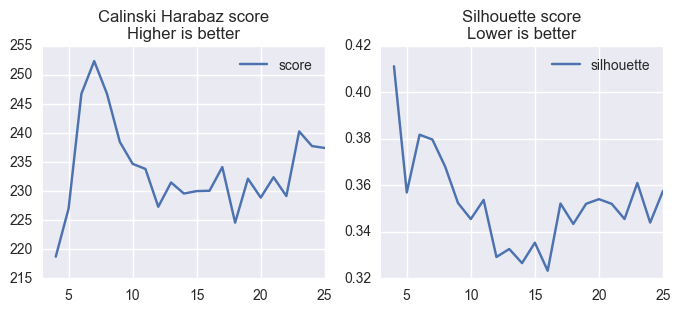

In [80]:
cluster.evaluate_clusters()

From the figures above, it is difficult to determine an optimal number of clusters. The silhouette score clearly shows that we need more than 5 clusters. 6 looks like a good number, but we also look at 12 to see if it will provide a better model.

In [97]:
labeled_plants = cluster.label_and_export(k=6)

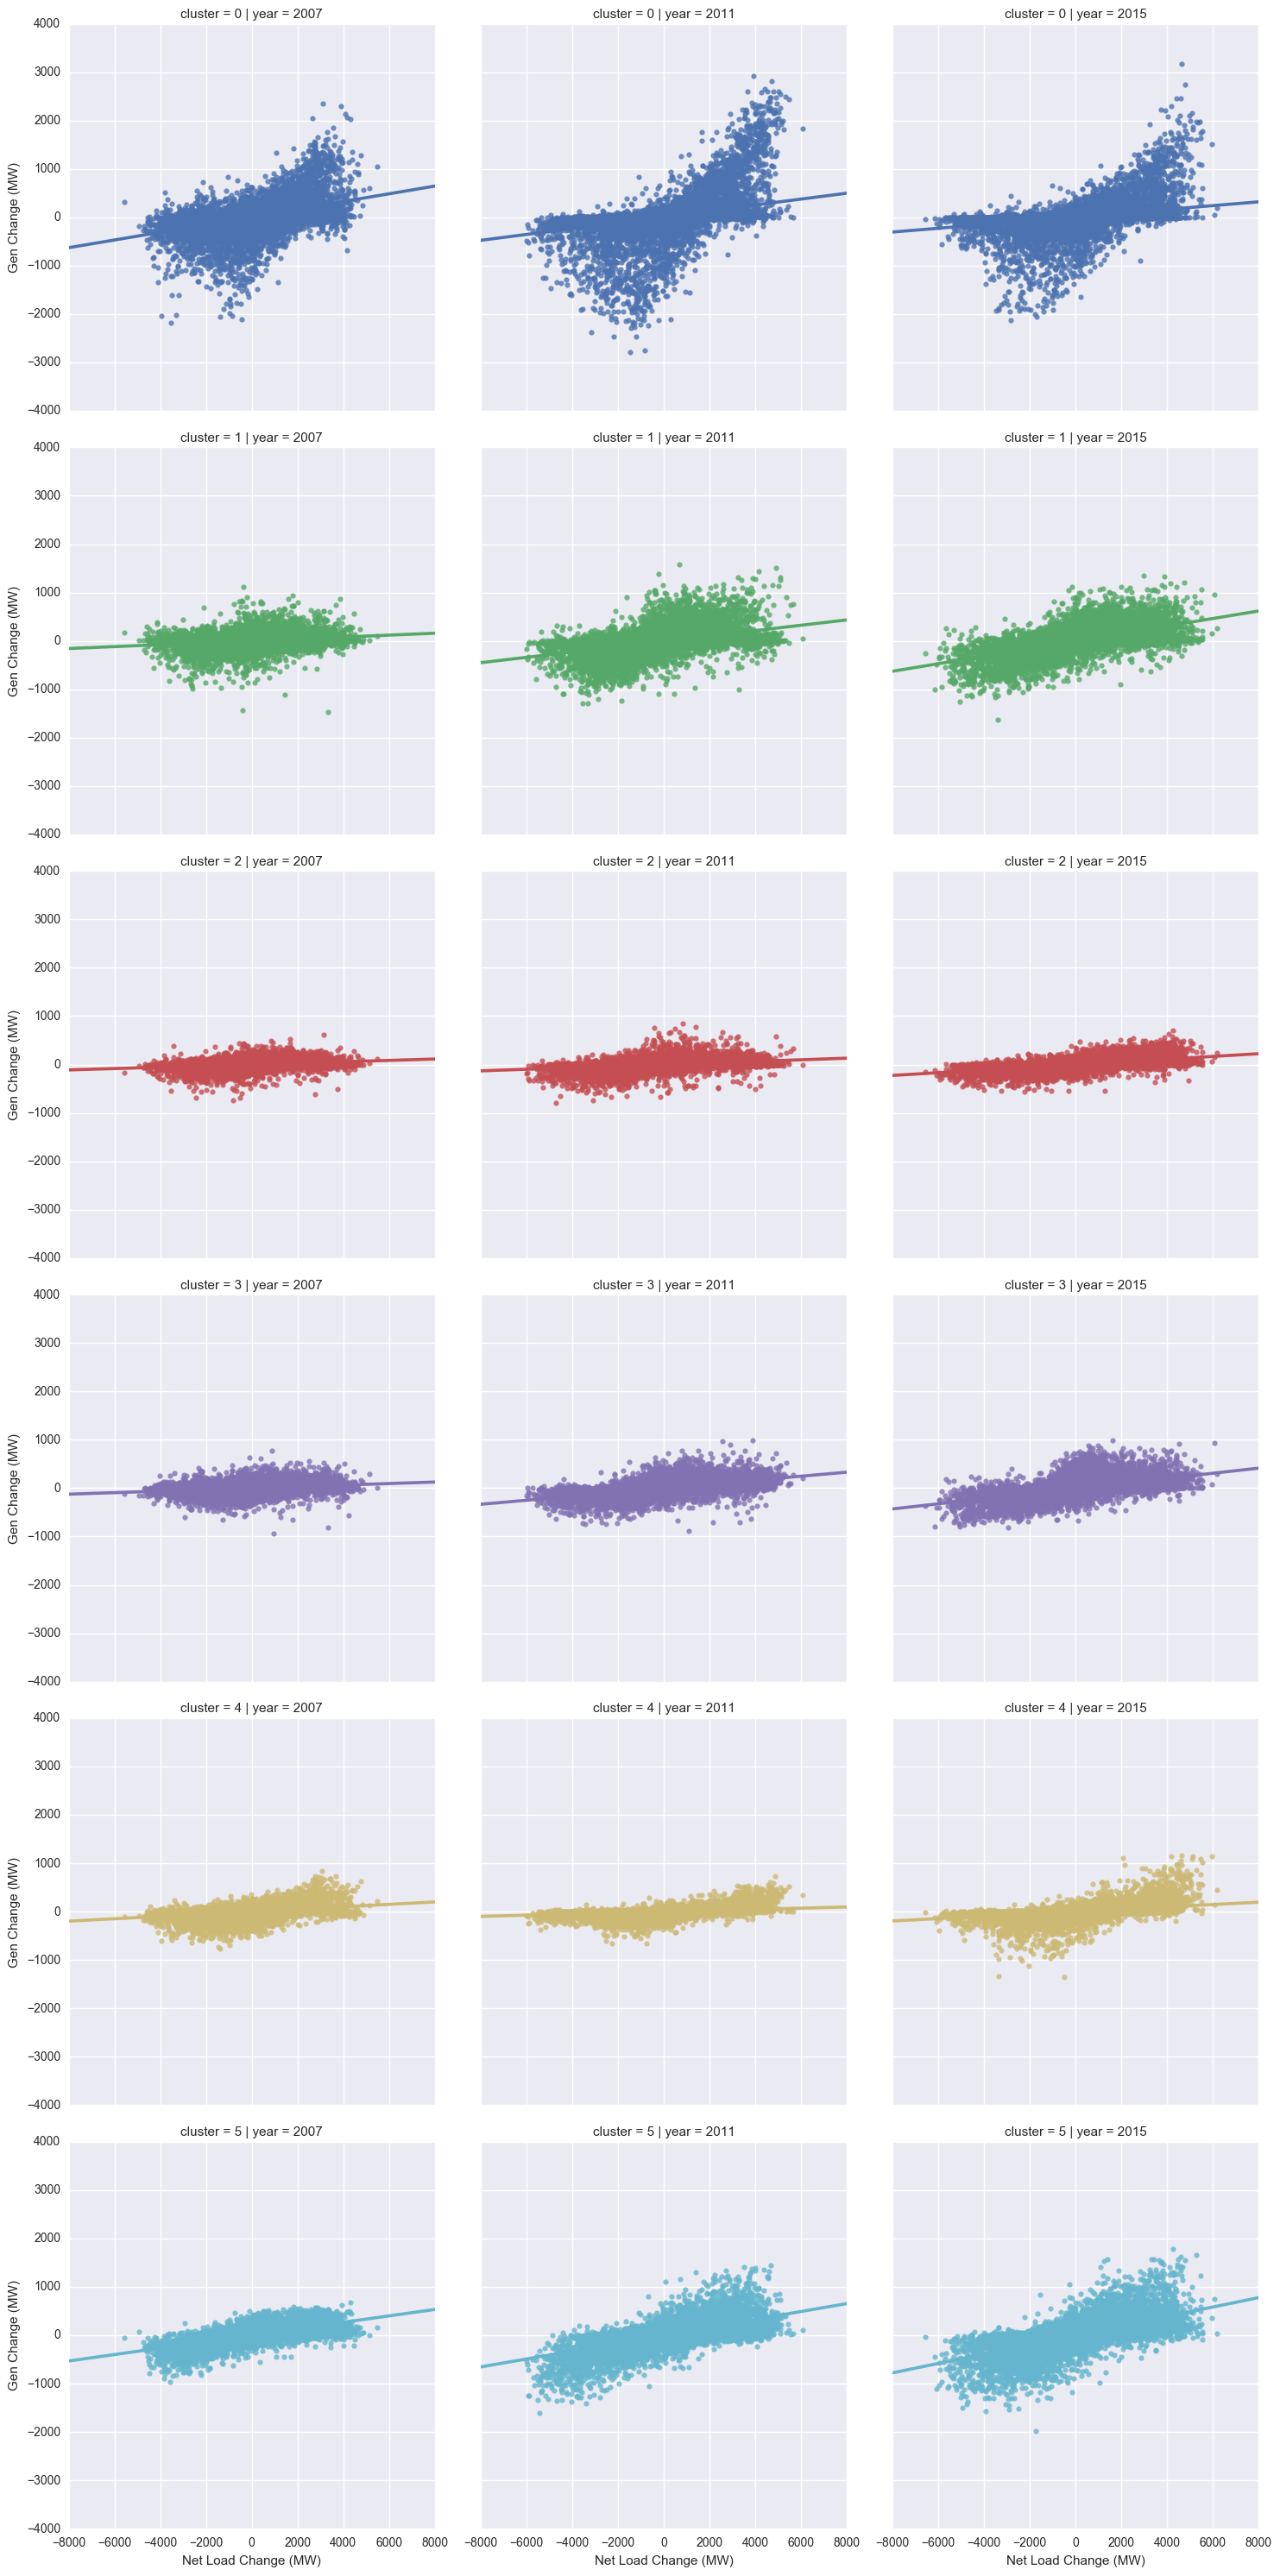

In [82]:
cluster.plot_clusters(ercot, allEPA, labeled_plants)

In [83]:
labeled_plants = cluster.label_and_export(k=7)

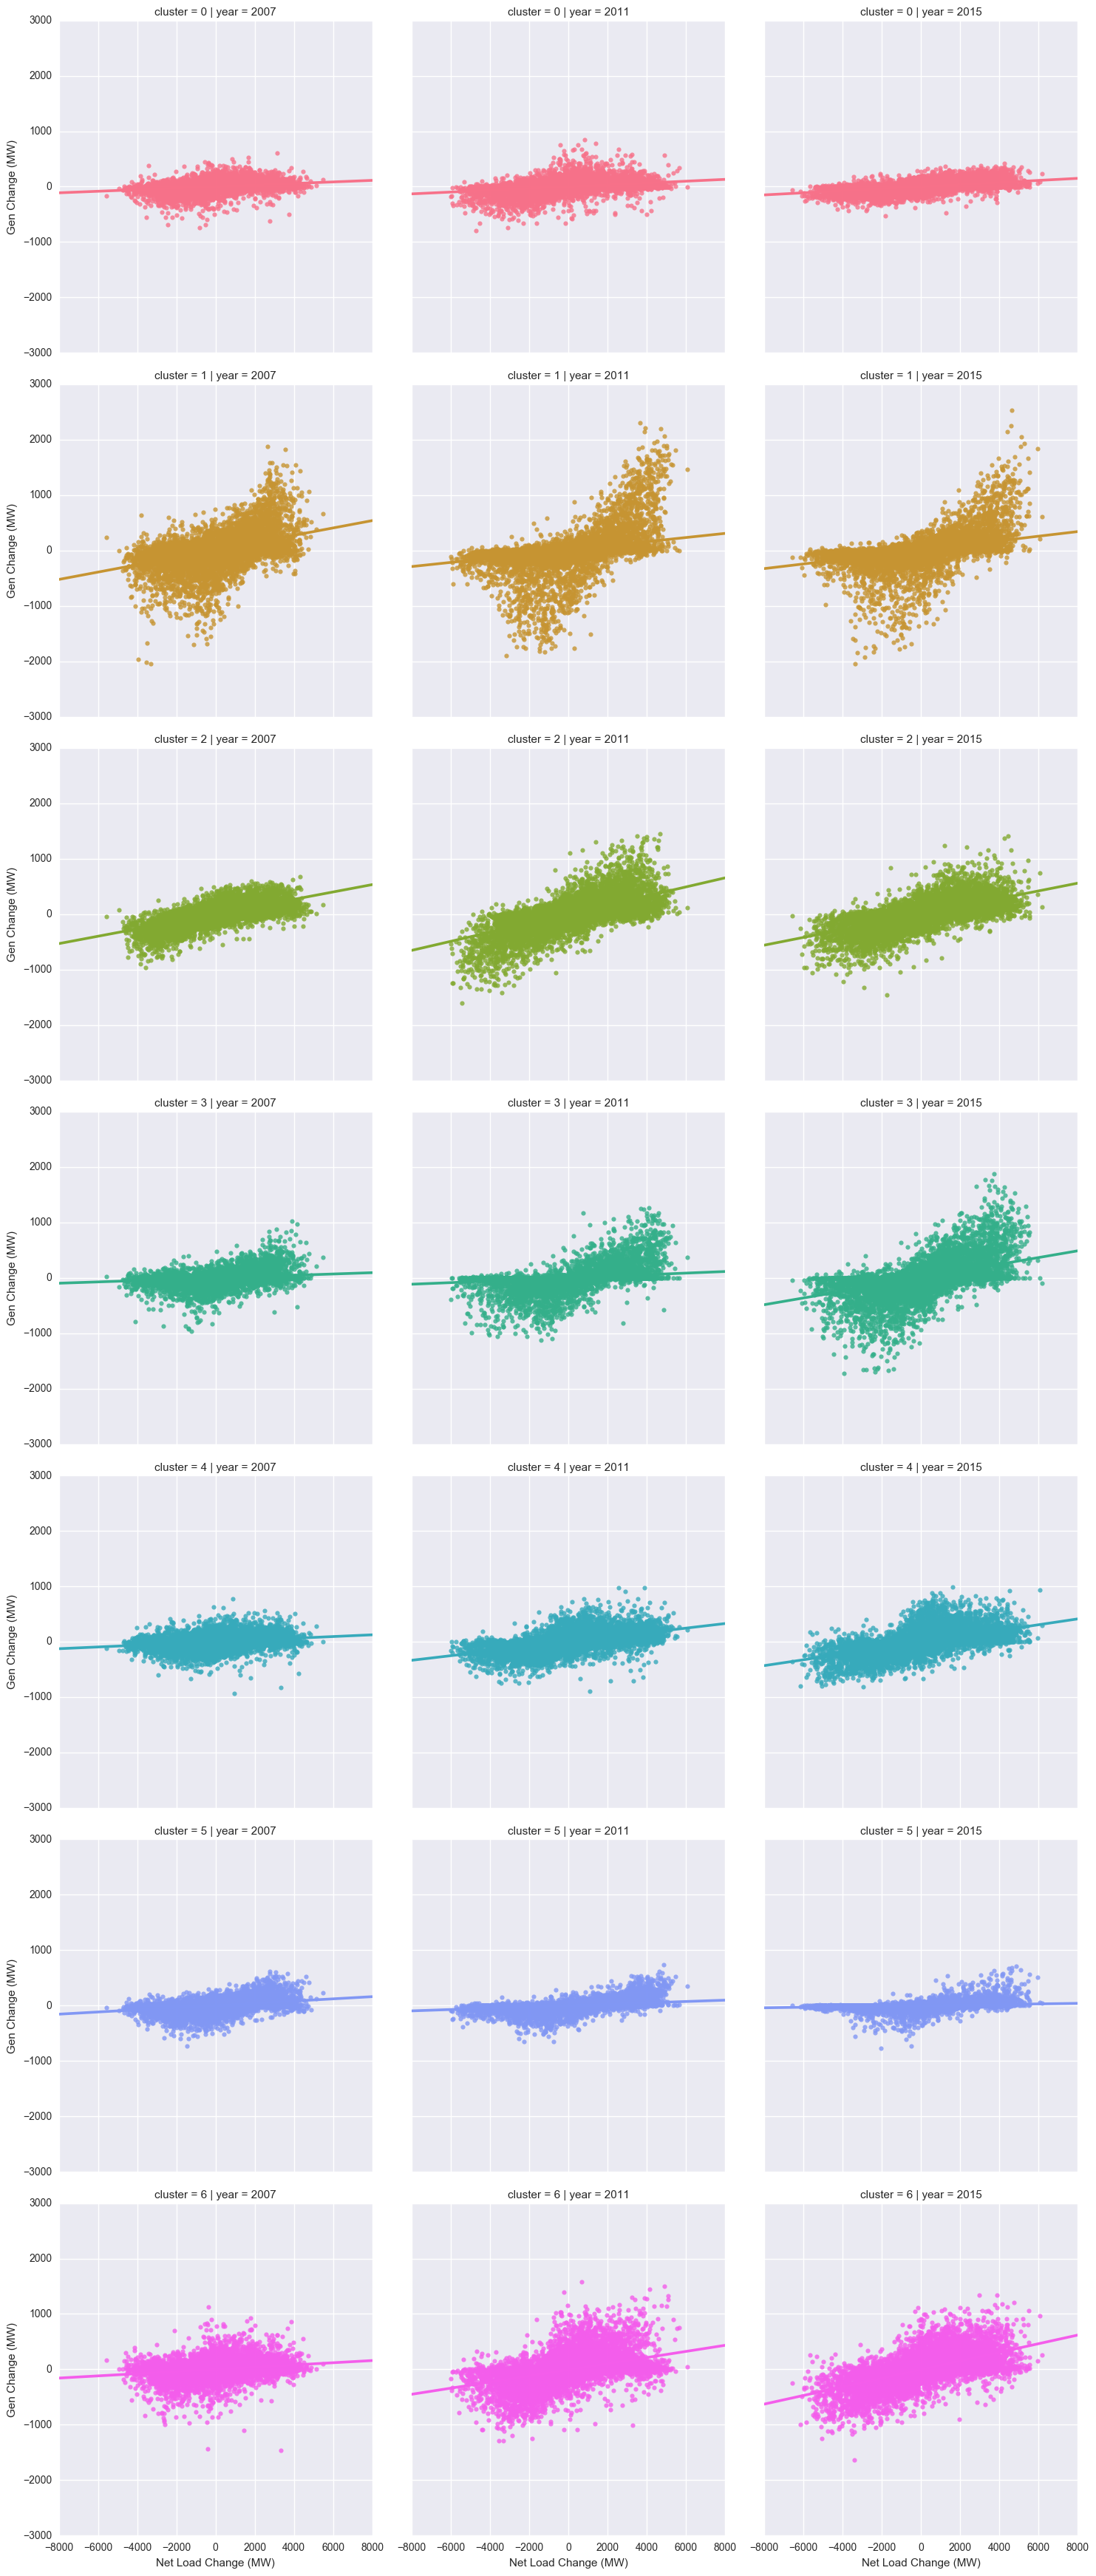

In [84]:
cluster.plot_clusters(ercot, allEPA, labeled_plants)

In [85]:
labeled_plants = cluster.label_and_export(k=8)

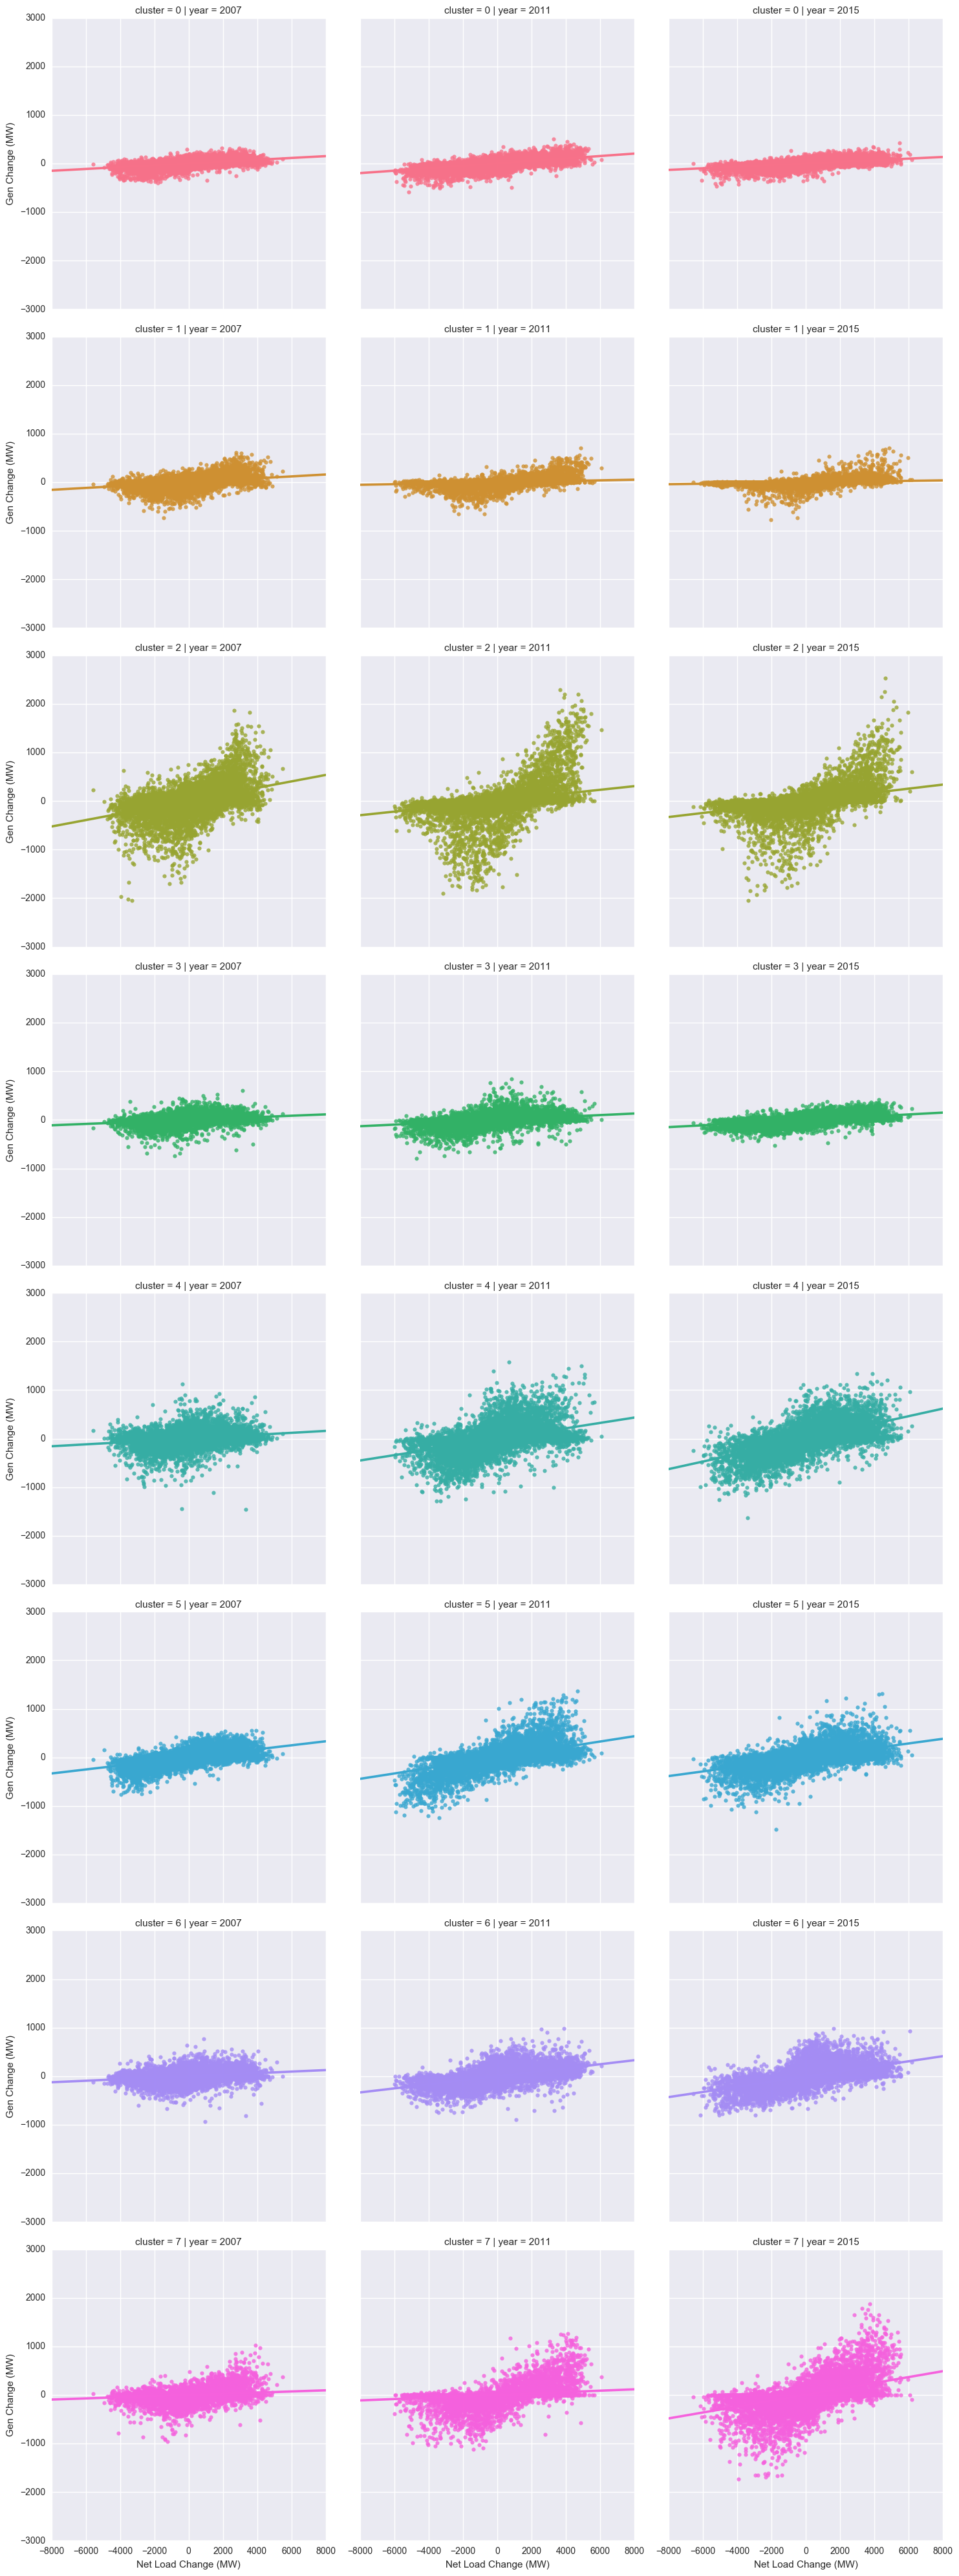

In [86]:
cluster.plot_clusters(ercot, allEPA, labeled_plants)

In [89]:
labeled_plants = cluster.label_and_export(k=9)

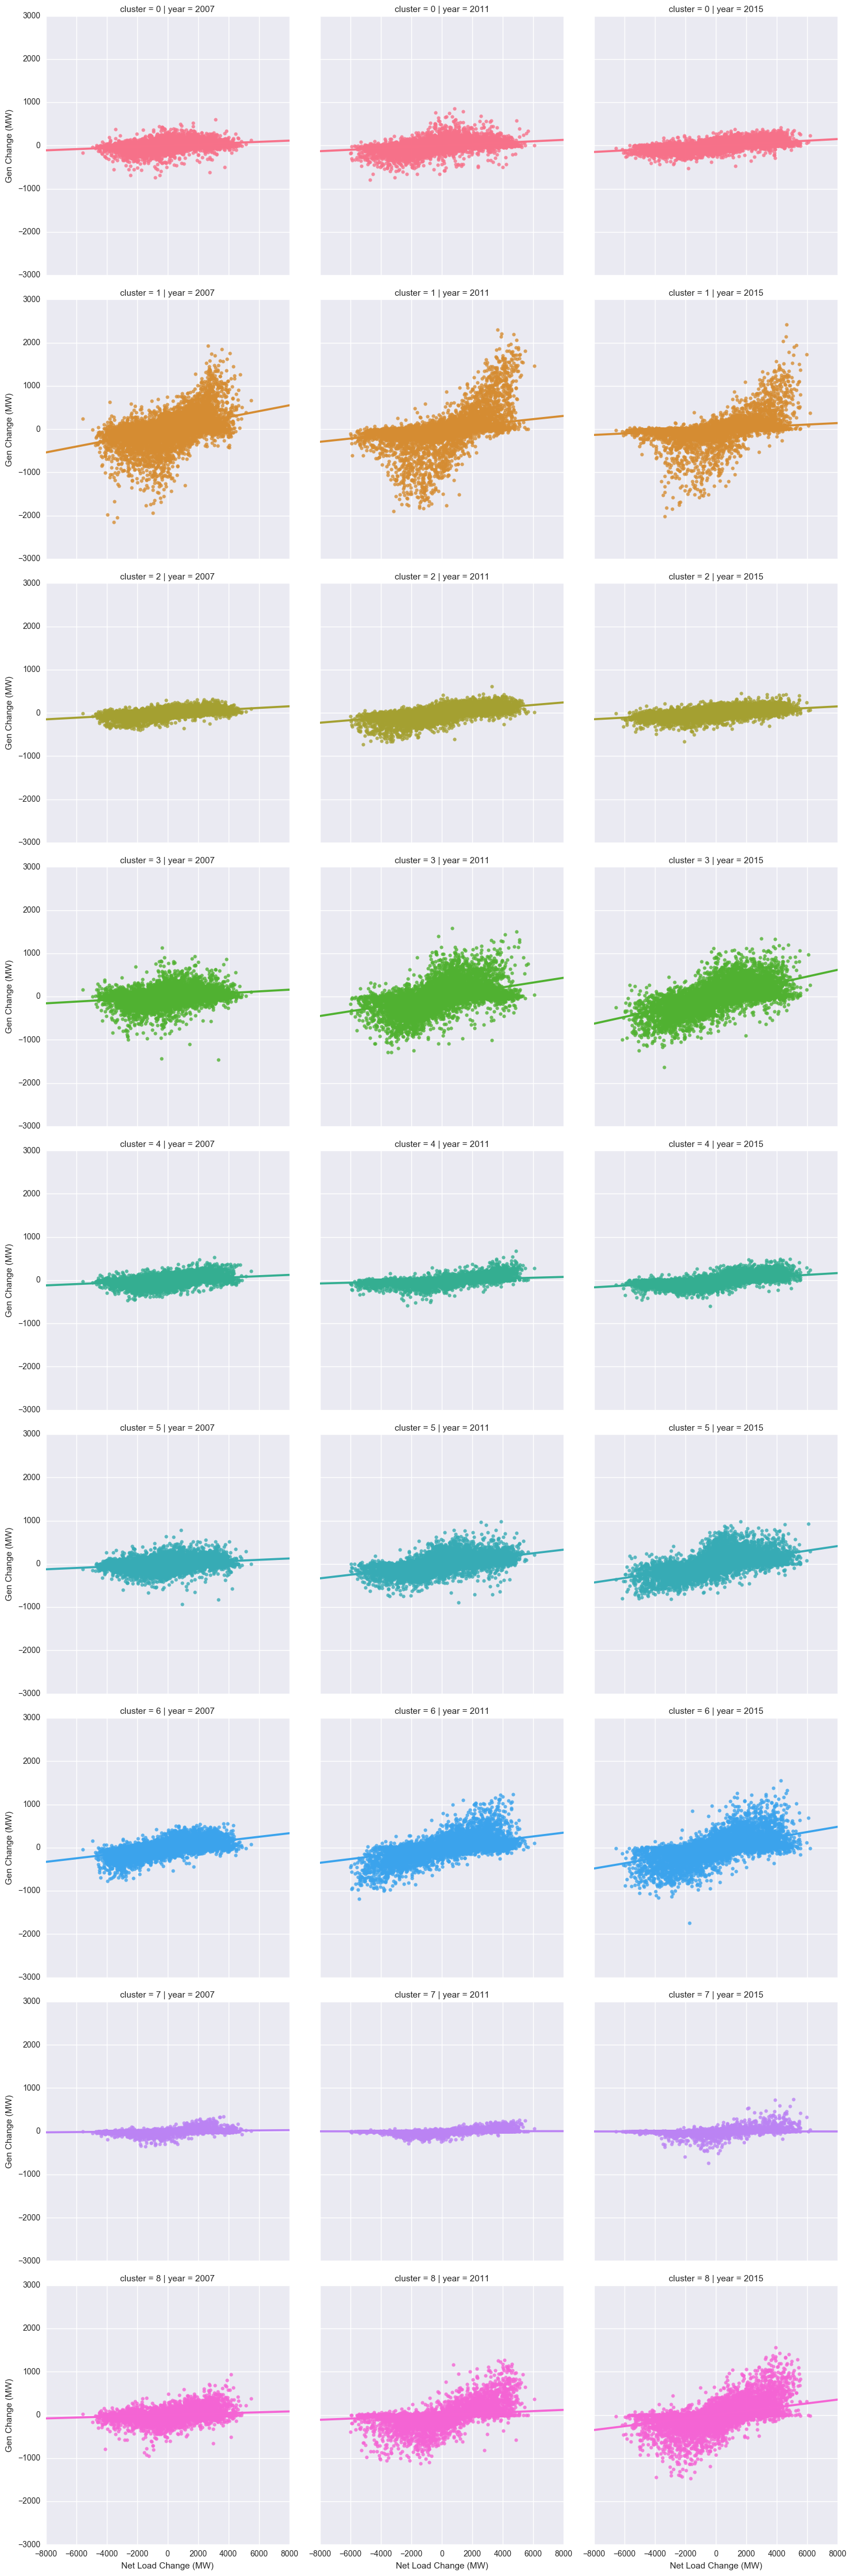

In [90]:
cluster.plot_clusters(ercot, allEPA, labeled_plants)

In [87]:
labeled_plants = cluster.label_and_export(k=10)

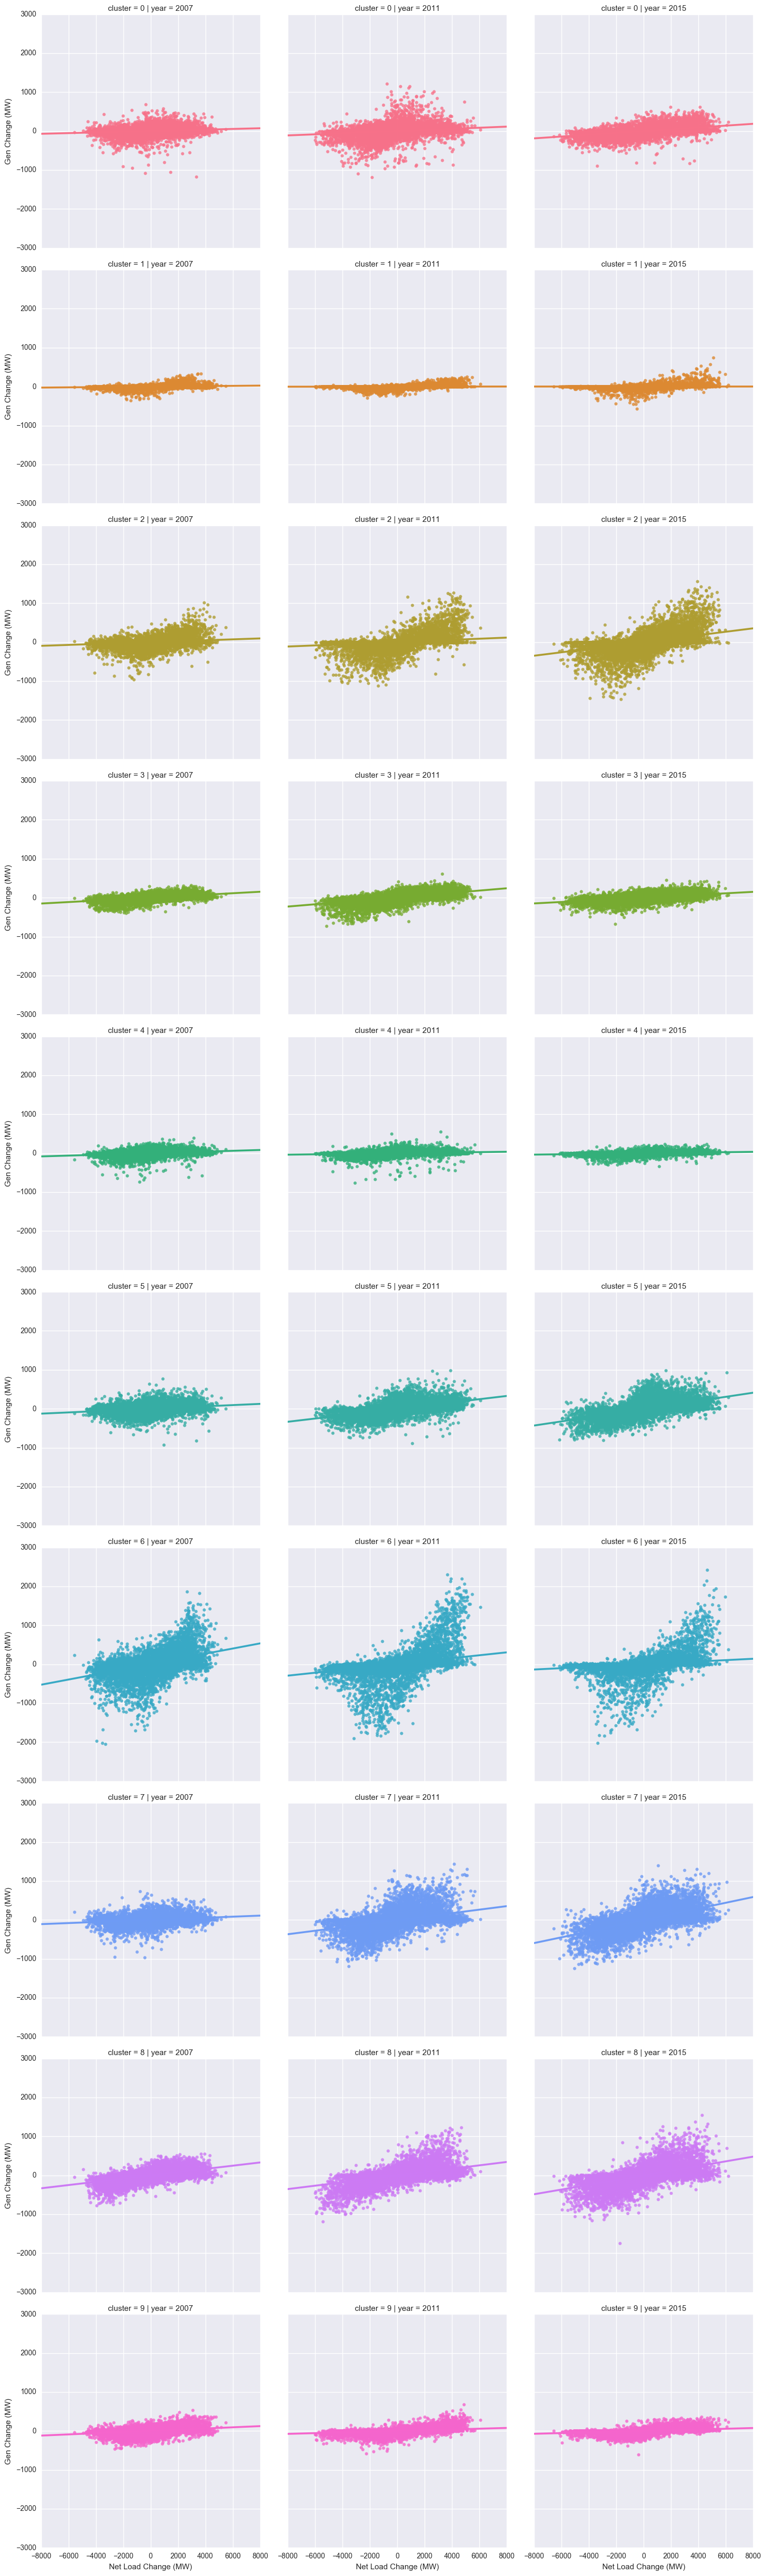

In [88]:
cluster.plot_clusters(ercot, allEPA, labeled_plants)

In [ ]:
labeled_plants = cluster.label_and_export(k=11)

In [ ]:
cluster.plot_clusters(ercot, allEPA, labeled_plants)

In [ ]:
labeled_plants = cluster.label_and_export(k=12)

In [ ]:
cluster.plot_clusters(ercot, allEPA, labeled_plants)

## Calculating hourly generation change
Generation change by group/cluster

In [91]:
from MarginalUnit import Marginal_Unit

In [ ]:
# cluster_df = pd.read_csv('Cluster_Data.csv')

In [98]:
margUnit = Marginal_Unit(ercot, allEPA, labeled_plants, eia860Dict, fuel_price)

In [99]:
X = margUnit.getX()
y = margUnit.getY()

Save dataframes to csv

In [100]:
x_fn = 'x.csv'
y_fn = 'y.csv'
x_path = os.path.join(x_fn)
y_path = os.path.join(y_fn)

X.to_csv(x_path, index=None)
y.to_csv(y_path, index=None)

In [101]:
#Load dataframes from csv

X = pd.read_csv(x_path)
y = pd.read_csv(y_path)

In [102]:
X.tail()

cluster  Year  nameplate_capacity             DATETIME  \
473329        5  2015             10014.8  2015-12-31 19:00:00   
473330        5  2015             10014.8  2015-12-31 20:00:00   
473331        5  2015             10014.8  2015-12-31 21:00:00   
473332        5  2015             10014.8  2015-12-31 22:00:00   
473333        5  2015             10014.8  2015-12-31 23:00:00   

        GROSS LOAD (MW)  ERCOT Load, MW  Total Wind Installed, MW  \
473329           3625.0     39908.77734                   16170.0   
473330           3319.0     38736.85938                   16170.0   
473331           3332.0     37587.70313                   16170.0   
473332           3214.0     36356.26172                   16170.0   
473333           3173.0     35150.33984                   16170.0   

        Total Wind Output, MW  Wind Output, % of Installed  \
473329            3824.932373                    23.654498   
473330            4625.632813                    28.606264   
473331            4957.714844                    30.659956   
473332            4699.097656                    29.060592   
473333            4313.125000                    26.673624   

        Wind Output, % of Load  1-hr MW change  1-hr % change  Net Load (MW)  \
473329                9.584188      483.971191      14.485987   36083.844967   
473330               11.941166      800.700440      20.933715   34111.226567   
473331               13.189725      332.082031       7.179170   32629.988286   
473332               12.925140     -258.617188      -5.216460   31657.164064   
473333               12.270507     -385.972656      -8.213761   30837.214840   

        Net Load Change (MW)  Month  NG Price ($/mcf)  All coal  Lignite  \
473329          -1172.357911     12              2.23     28.53    24.04   
473330          -1972.618400     12              2.23     28.53    24.04   
473331          -1481.238281     12              2.23     28.53    24.04   
473332           -972.824222     12              2.23     28.53    24.04   
473333           -819.949224     12              2.23     28.53    24.04   

        Subbituminous  
473329          32.55  
473330          32.55  
473331          32.55  
473332          32.55  
473333          32.55

In [103]:
y.tail()

DATETIME  cluster  Gen Change (MW)
473329  2015-12-31 19:00:00        5            -69.0
473330  2015-12-31 20:00:00        5           -306.0
473331  2015-12-31 21:00:00        5             13.0
473332  2015-12-31 22:00:00        5           -118.0
473333  2015-12-31 23:00:00        5            -41.0

## Model training

In [105]:
X = pd.read_csv(x_path)
y = pd.read_csv(y_path)

#### Ratio of prices
Divide coal prices by natural gas price, drop natural gas price

In [104]:
for fuel in ['All coal', 'Lignite', 'Subbituminous']:
    X.loc[:,fuel] = X.loc[:,fuel].values/X.loc[:,'NG Price ($/mcf)'].values
    
X.drop('NG Price ($/mcf)', axis=1, inplace=True)

####  One-hot encoding of the cluster variable

In [109]:
cluster_ids = X['cluster'].unique()
for cluster in cluster_ids:
    X['cluster_{}'.format(cluster)] = np.eye(len(cluster_ids))[X['cluster'],cluster]

In [110]:
# Drop unnecessary columns and replace nan's with 0

X_cols = ['nameplate_capacity', 'GROSS LOAD (MW)', 'ERCOT Load, MW',
          'Total Wind Installed, MW', 'Total Wind Output, MW', 'Net Load Change (MW)',
          'NG Price ($/mcf)', 'All coal', 'Lignite', 'Subbituminous']
X_cluster_cols = ['cluster_{}'.format(cluster) for cluster in cluster_ids]

X_clean = X.loc[:,X_cols+X_cluster_cols]
X_clean.fillna(0, inplace=True)

y_clean = y.loc[:,'Gen Change (MW)']
y_clean.fillna(0, inplace=True)

In [111]:
print X_clean.shape
print y_clean.shape

(473334, 16)
(473334L,)


#### Split into training, validation, testing

In [112]:
X_train = X_clean.loc[(X['Year']<2012),:]
y_train = y_clean.loc[(X['Year']<2012)]

X_va = X_clean.loc[X['Year'].isin([2012, 2013]),:]
y_va = y_clean.loc[X['Year'].isin([2012, 2013])]

X_test = X_clean.loc[X['Year']>2013,:]
y_test = y_clean.loc[X['Year']>2013]

In [113]:
print X_va.shape, y_va.shape

(105264, 16) (105264L,)


Need scaled versions of the X data for some of the models

In [116]:
X_train_scaled = StandardScaler().fit_transform(X_train)
X_va_scaled = StandardScaler().fit_transform(X_va)
X_test_scaled = StandardScaler().fit_transform(X_test)

Check size of all arrays

In [117]:
print X_train_scaled.shape, y_train.shape
print X_va_scaled.shape, y_va.shape
print X_test_scaled.shape, y_test.shape

(262944L, 16L) (262944L,)
(105264L, 16L) (105264L,)
(105126L, 16L) (105126L,)


## Linear Regression (OLS)

In [118]:
lm = LinearRegression()
lm.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [119]:
lm.score(X_va_scaled, y_va)

0.27427295343597213

## References
1. Siler-Evans, K., Azevedo, I. L., & Morgan, M. G. (2012). Marginal Emissions Factors for the U.S. Electricity System. Environmental Science & Technology, 46(9), 4742–4748.
2. Graff Zivin, J. S., Kotchen, M. J. & Mansur, E. T. Spatial and temporal heterogeneity of marginal emissions: Implications for electric cars and other electricity-shifting policies. Journal of Economic Behavior & Organization 107, Part A, 248–268 (2014).
3. http://www.ercot.com/gridinfo/generation
4. https://www.eia.gov/electricity/data/eia923/
5. https://www.eia.gov/electricity/data/eia860/
6. http://www.eia.gov/dnav/ng/hist/n3045tx3m.htm
7. [EIA Coal Data Browser](http://www.eia.gov/beta/coal/data/browser/#/topic/45?agg=1,0&geo=vvvvvvvvvvvvo&rank=l&linechart=~~COAL.SHIP_PLANT_PRICE.TX-LIG.Q~COAL.SHIP_PLANT_PRICE.TX-SUB.Q&columnchart=COAL.SHIP_PLANT_PRICE.US-TOT.Q&map=COAL.SHIP_PLANT_PRICE.US-TOT.Q&freq=Q&start=200801&end=201601&chartindexed=0&ctype=linechart&ltype=pin&rtype=s&maptype=0&rse=0&pin=)
8. https://ampd.epa.gov/ampd/